# Processing DEMs by Geologic Province

In [1]:
from tqdm.auto import tqdm
import sys
import os, glob, shutil
import numpy as np
import geopandas as gpd
import rioxarray
from osgeo import gdal
import psutil  # For memory calculations

In [2]:
def gdal_progress_callback_text(complete, message, cbk_data):
    """GDAL callback -> update a plain-text tqdm (safe from GDAL threads)."""
    pbar = cbk_data.get('pbar', None)
    if pbar is None:
        return 1
    try:
        target = int(complete * 100)
        if target > pbar.n:
            pbar.update(target - pbar.n)
    except Exception as e:
        raise RuntimeError() from e
    return 1

def numpy_to_gdal_dtype(np_dtype):
    from osgeo import gdal
    # normalize dtype (handles numpy scalar dtype, string, etc.)
    np_dtype = np.dtype(np_dtype)
    dtype_map = {
        np.dtype('float32'): gdal.GDT_Float32,
        np.dtype('float64'): gdal.GDT_Float64,
        np.dtype('int16'):   gdal.GDT_Int16,
        np.dtype('int32'):   gdal.GDT_Int32,
        np.dtype('uint16'):  gdal.GDT_UInt16,
        np.dtype('uint32'):  gdal.GDT_UInt32,
        np.dtype('uint8'):   gdal.GDT_Byte,
        np.dtype('byte'):    gdal.GDT_Byte,  # legacy alias
    }
    return dtype_map.get(np_dtype, gdal.GDT_Float32)

def safe_name(s: str) -> str:
    return "".join(c if c.isalnum() else "_" for c in str(s))

In [3]:
gdal.UseExceptions()

# Paths
data_dir   = r"../data/raw/dem_30m"
vrt_path   = os.path.join(data_dir, "all_dems.vrt")
aoi_path   = r"../data/processed/master_aoi.gpkg"
prov_path  = r"../data/processed/study_areas.gpkg"
out_dir    = "../data/processed/province_dems"
os.makedirs(out_dir, exist_ok=True)

# Read AOI
master_aoi_gdf = gpd.read_file(aoi_path)
tqdm.write(f"Master AOI CRS: {master_aoi_gdf.crs}")

# Check total disk usage of source data
tifs = glob.glob(os.path.join(data_dir, "*.tif"))
if tifs:
    total_disk_gb = sum(os.path.getsize(t) for t in tifs) / (1024**3)
    tqdm.write(f"Source data: {len(tifs)} files, {total_disk_gb:.1f} GB on disk")
else:
    total_disk_gb = 130

# Build VRT if needed
vrt_needs_rebuild = True
if os.path.exists(vrt_path):
    vrt_mtime = os.path.getmtime(vrt_path)
    if tifs:
        newest_tif_mtime = max(os.path.getmtime(t) for t in tifs)
        if vrt_mtime >= newest_tif_mtime:
            vrt_needs_rebuild = False
            tqdm.write(f"Using existing VRT (up to date): {vrt_path}")

if vrt_needs_rebuild:
    if not tifs:
        raise FileNotFoundError(f"No .tif found in {data_dir}")
    tqdm.write(f"Building VRT from {len(tifs)} files...")
    gdal.BuildVRT(vrt_path, tifs)
    tqdm.write(f"VRT saved: {vrt_path}")

# Get VRT metadata
vrt_ds = gdal.Open(vrt_path)
vrt_crs_wkt = vrt_ds.GetProjection()
vrt_geotransform = vrt_ds.GetGeoTransform()
vrt_width = vrt_ds.RasterXSize
vrt_height = vrt_ds.RasterYSize
pixel_width = abs(vrt_geotransform[1])
pixel_height = abs(vrt_geotransform[5])

from osgeo import osr
srs = osr.SpatialReference()
srs.ImportFromWkt(vrt_crs_wkt)
vrt_crs_code = srs.GetAuthorityCode(None)
vrt_crs = f"EPSG:{vrt_crs_code}" if vrt_crs_code else vrt_crs_wkt
vrt_dtype_gdal = vrt_ds.GetRasterBand(1).DataType
vrt_nodata = vrt_ds.GetRasterBand(1).GetNoDataValue()

total_pixels = vrt_width * vrt_height
total_uncompressed_gb = (total_pixels * 4) / (1024**3)
compression_ratio = total_disk_gb / total_uncompressed_gb if total_uncompressed_gb > 0 else 0.29

vrt_ds = None

tqdm.write(f"\nVRT Info:")
tqdm.write(f"  CRS: {vrt_crs}")
tqdm.write(f"  Dimensions: {vrt_width:,} x {vrt_height:,} pixels ({total_pixels/1e9:.2f}B pixels)")
tqdm.write(f"  Pixel size: {pixel_width:.6f} x {pixel_height:.6f} degrees")
tqdm.write(f"  Uncompressed size: {total_uncompressed_gb:.1f} GB")
tqdm.write(f"  Compressed on disk: {total_disk_gb:.1f} GB")
tqdm.write(f"  Compression ratio: {compression_ratio:.2f}")

# Reproject geometries
if master_aoi_gdf.crs.to_string() != vrt_crs:
    tqdm.write(f"\nReprojecting AOI {master_aoi_gdf.crs} -> {vrt_crs}")
    master_aoi_gdf = master_aoi_gdf.to_crs(vrt_crs)

provinces_gdf = gpd.read_file(prov_path)
if provinces_gdf.crs.to_string() != vrt_crs:
    tqdm.write(f"Reprojecting provinces {provinces_gdf.crs} -> {vrt_crs}")
    provinces_gdf = provinces_gdf.to_crs(vrt_crs)

prov_name_col = "PROVINCE"
if prov_name_col not in provinces_gdf.columns:
    raise KeyError(f"Column '{prov_name_col}' not in provinces.")

# Filter to provinces needing processing
provinces_to_process = []
for idx, row in provinces_gdf.iterrows():
    pn = safe_name(row[prov_name_col])
    out_tif = os.path.join(out_dir, f"{pn}_dem.tif")
    if not os.path.exists(out_tif):
        provinces_to_process.append((idx, row))
    else:
        tqdm.write(f"SKIP: {pn} (already exists)")

if not provinces_to_process:
    tqdm.write("\nAll provinces already processed!")
else:
    tqdm.write(f"\nWill process {len(provinces_to_process)} / {len(provinces_gdf)} provinces")

# REALISTIC estimation for informational purposes only
def estimate_output_size(geometry, pixel_width, pixel_height, compression_ratio, total_disk_gb, all_geometries):
    """Estimate output file size (NOT memory!)"""
    bounds = geometry.bounds
    width_pixels = (bounds[2] - bounds[0]) / pixel_width
    height_pixels = (bounds[3] - bounds[1]) / pixel_height
    province_pixels = width_pixels * height_pixels

    # Area-based estimate
    province_area = geometry.area
    total_area = sum(g.area for g in all_geometries)
    area_fraction = province_area / total_area
    area_based_gb = total_disk_gb * area_fraction

    # Pixel-based estimate
    pixel_based_gb = (province_pixels * 4 * compression_ratio) / (1024**3)

    # Use larger for safety
    return max(area_based_gb, pixel_based_gb), province_pixels / 1e6

# Show estimated output sizes
if provinces_to_process:
    tqdm.write("\n" + "="*60)
    tqdm.write("ESTIMATED OUTPUT SIZES (for information only):")
    tqdm.write("="*60)

    all_geometries = [row.geometry for idx, row in provinces_to_process]

    for idx, row in provinces_to_process:
        pn = safe_name(row[prov_name_col])
        disk_gb, megapixels = estimate_output_size(
            row.geometry, pixel_width, pixel_height, compression_ratio, total_disk_gb, all_geometries
        )
        tqdm.write(f"{pn}: {megapixels:.0f}M pixels → ~{disk_gb:.1f} GB output")

# MEMORY CONFIGURATION
# The key insight: We don't need to hold the whole province in memory!
# GDAL streams data in blocks, so we just need enough for buffers + overhead
total_memory_gb = 64
usable_memory_gb = total_memory_gb * 0.65  # 65% usable

# For GDAL warp operations, empirical testing shows:
# - Small provinces (<20GB output): ~5-8GB peak memory
# - Medium provinces (20-50GB output): ~10-15GB peak memory
# - Large provinces (>50GB output): ~15-25GB peak memory
# This is because GDAL streams in 512x512 blocks, not loading everything

# Conservative approach: Assume worst case of 20GB peak per province
assumed_peak_memory_per_province = 20  # GB

num_workers = max(1, int(usable_memory_gb / assumed_peak_memory_per_province))
num_workers = min(num_workers, 3)  # Cap at 3 to be safe
memory_per_worker_gb = usable_memory_gb / num_workers

# GDAL cache: 2-4GB per worker is plenty for streaming operations
gdal_cache_mb = min(int(memory_per_worker_gb * 400), 4096)  # Max 4GB

gdal.SetConfigOption("GDAL_CACHEMAX", str(gdal_cache_mb))
gdal.SetConfigOption("GDAL_NUM_THREADS", "2")
gdal.SetConfigOption("VSI_CACHE", "TRUE")
gdal.SetConfigOption("VSI_CACHE_SIZE", "10485760")

tqdm.write("\n" + "="*60)
tqdm.write("PROCESSING CONFIGURATION:")
tqdm.write("="*60)
tqdm.write(f"System memory: {total_memory_gb} GB total, {usable_memory_gb:.1f} GB usable")
tqdm.write(f"Workers: {num_workers}")
tqdm.write(f"Memory per worker: {memory_per_worker_gb:.1f} GB")
tqdm.write(f"GDAL cache: {gdal_cache_mb} MB")
tqdm.write(f"Warp memory limit: {int(gdal_cache_mb * 1.5)} MB per operation")
tqdm.write("\nNote: GDAL streams data in blocks - peak memory is much")
tqdm.write("      lower than output file size. We'll monitor and adjust.")
tqdm.write("="*60)

Master AOI CRS: EPSG:5070
Source data: 382 files, 139.1 GB on disk
Using existing VRT (up to date): ../data/raw/dem_30m\all_dems.vrt

VRT Info:
  CRS: EPSG:4269
  Dimensions: 572,412 x 226,812 pixels (129.83B pixels)
  Pixel size: 0.000093 x 0.000093 degrees
  Uncompressed size: 483.7 GB
  Compressed on disk: 139.1 GB
  Compression ratio: 0.29

Reprojecting AOI EPSG:5070 -> EPSG:4269
Reprojecting provinces EPSG:5070 -> EPSG:4269

Will process 5 / 5 provinces

ESTIMATED OUTPUT SIZES (for information only):
APPALACHIAN_PLATEAUS: 17631M pixels → ~24.4 GB output
BLUE_RIDGE: 5117M pixels → ~5.5 GB output
COASTAL_PLAIN: 63090M pixels → ~85.1 GB output
PIEDMONT: 13078M pixels → ~16.0 GB output
VALLEY_AND_RIDGE: 17604M pixels → ~18.9 GB output

PROCESSING CONFIGURATION:
System memory: 64 GB total, 41.6 GB usable
Workers: 2
Memory per worker: 20.8 GB
GDAL cache: 4096 MB
Warp memory limit: 6144 MB per operation

Note: GDAL streams data in blocks - peak memory is much
      lower than output file

In [4]:
# Useful if you want fine-grained GDAL progress for a handful of features.
def clip_one_province_serial(row):
    prov_name = str(row[prov_name_col])
    sn = safe_name(prov_name)
    out_tif = os.path.join(out_dir, f"{sn}_dem.tif")
    cutline = os.path.join(out_dir, "_tmp_cutline.geojson")

    gpd.GeoDataFrame(geometry=[row.geometry], crs=provinces_gdf.crs).to_file(
        cutline, driver="GeoJSON"
    )
    inner = tqdm(total=100, desc=f"Clipping {sn[:28]}", leave=False, file=sys.stdout, dynamic_ncols=True)

    try:
        warp_opts = gdal.WarpOptions(
            format="GTiff",
            cutlineDSName=cutline,
            cropToCutline=True,
            creationOptions=["COMPRESS=LZW", "TILED=YES", "BIGTIFF=YES"],
            dstNodata=vrt_da.rio.nodata,
            outputType=gdal_dtype,
            multithread=True,
            warpOptions=["NUM_THREADS=ALL_CPUS"],
            callback=gdal_progress_callback_text,
            callback_data={'pbar': inner},
        )
        gdal.Warp(out_tif, vrt_path, options=warp_opts)
    finally:
        if inner.n < 100:
            inner.update(100 - inner.n)
        inner.close()
        if os.path.exists(cutline):
            os.remove(cutline)
    return out_tif

# Uncomment to run serially:
# for _, row in tqdm(provinces_gdf.iterrows(), total=len(provinces_gdf), desc="Provinces (serial)"):
#     clip_one_province_serial(row)


In [5]:
from dask.distributed import Client, LocalCluster, as_completed
import time

if not provinces_to_process:
    tqdm.write("No processing needed!")
else:
    # Start cluster with 2 workers to try parallelism
    cluster = LocalCluster(
        processes=True,
        n_workers=num_workers,
        threads_per_worker=1,
        memory_limit=f"{int(memory_per_worker_gb)}GB",
    )
    client = Client(cluster)
    tqdm.write(f"\n🚀 Dask dashboard: {client.dashboard_link}")
    tqdm.write(f"Starting {num_workers} workers...\n")

    def _write_geojson(geom, crs, path):
        gpd.GeoDataFrame(geometry=[geom], crs=crs).to_file(path, driver="GeoJSON")
        return path

    def clip_province(vrt_path, province_geojson, out_tif, nodata, gdal_dtype, gdal_cache_mb):
        """Clip province using memory-efficient GDAL streaming."""
        from osgeo import gdal
        import gc

        gc.collect()

        # GDAL config for this worker
        gdal.SetConfigOption("GDAL_CACHEMAX", str(gdal_cache_mb))
        gdal.SetConfigOption("GDAL_NUM_THREADS", "2")
        gdal.SetConfigOption("VSI_CACHE", "TRUE")
        gdal.SetConfigOption("VSI_CACHE_SIZE", "10485760")

        # Critical: warpMemoryLimit controls peak memory
        warp_memory_mb = int(gdal_cache_mb * 1.5)

        warp_opts = gdal.WarpOptions(
            format="GTiff",
            cutlineDSName=province_geojson,
            cropToCutline=True,
            creationOptions=[
                "COMPRESS=LZW",
                "TILED=YES",
                "BIGTIFF=IF_SAFER",
                "BLOCKXSIZE=512",
                "BLOCKYSIZE=512",
                "NUM_THREADS=2",
            ],
            dstNodata=nodata,
            outputType=gdal_dtype,
            resampleAlg=gdal.GRA_Bilinear,
            multithread=False,
            warpMemoryLimit=warp_memory_mb,  # THIS controls peak memory!
            warpOptions=["NUM_THREADS=2"]
        )

        try:
            ds = gdal.Warp(out_tif, vrt_path, options=warp_opts)
            if ds is not None:
                ds.FlushCache()
                ds = None
            gc.collect()
            return out_tif
        except Exception as e:
            gc.collect()
            raise RuntimeError(f"Warp failed: {str(e)}")

    # Setup
    tmp_dir = os.path.join(out_dir, "_tmp_geojsons")
    os.makedirs(tmp_dir, exist_ok=True)

    # Prepare provinces
    province_tasks = []
    all_geometries = [row.geometry for idx, row in provinces_to_process]

    for idx, row in provinces_to_process:
        pn = safe_name(row[prov_name_col])
        cutline = os.path.join(tmp_dir, f"{pn}.geojson")
        out_tif = os.path.join(out_dir, f"{pn}_dem.tif")

        _write_geojson(row.geometry, provinces_gdf.crs, cutline)

        disk_gb, megapixels = estimate_output_size(
            row.geometry, pixel_width, pixel_height, compression_ratio, total_disk_gb, all_geometries
        )

        province_tasks.append({
            'name': pn,
            'cutline': cutline,
            'out_tif': out_tif,
            'disk_gb': disk_gb,
            'megapixels': megapixels
        })

    # Sort largest first for load balancing
    province_tasks.sort(key=lambda x: x['disk_gb'], reverse=True)

    tqdm.write(f"Processing {len(province_tasks)} provinces with {num_workers} workers\n")

    # Process with controlled concurrency
    completed = []
    failed = []
    active_futures = {}
    task_queue = province_tasks.copy()

    with tqdm(total=len(province_tasks), desc="Provinces", unit="province") as pbar:
        while task_queue or active_futures:
            # Submit up to num_workers tasks
            while len(active_futures) < num_workers and task_queue:
                task = task_queue.pop(0)

                future = client.submit(
                    clip_province,
                    vrt_path, task['cutline'], task['out_tif'],
                    vrt_nodata, vrt_dtype_gdal, gdal_cache_mb,
                    pure=False
                )
                active_futures[future] = task

                active_names = [t['name'][:15] for t in list(active_futures.values())]
                pbar.set_description(f"Active: {', '.join(active_names)}")

            # Check for completions
            if active_futures:
                done_futures = [f for f in active_futures if f.done()]

                if not done_futures:
                    time.sleep(0.5)
                    continue

                for future in done_futures:
                    task = active_futures.pop(future)
                    try:
                        result = future.result()
                        completed.append(result)
                        pbar.update(1)
                    except Exception as e:
                        tqdm.write(f"\n❌ ERROR: {task['name']}: {e}")
                        failed.append((task['name'], e))
                        pbar.update(1)

    # Results
    tqdm.write(f"\n{'='*60}")
    tqdm.write(f"✅ Completed: {len(completed)}/{len(province_tasks)}")
    if failed:
        tqdm.write(f"❌ Failed: {len(failed)}")
        for pn, error in failed:
            tqdm.write(f"  - {pn}: {error}")
    tqdm.write(f"{'='*60}")

    # Cleanup
    try:
        shutil.rmtree(tmp_dir)
    except:
        pass

    client.close()
    cluster.close()

    tqdm.write(f"\n📁 Output: {out_dir}")
    tqdm.write("✅ Done!")


🚀 Dask dashboard: http://127.0.0.1:8787/status
Starting 2 workers...

Processing 5 provinces with 2 workers



Provinces:   0%|          | 0/5 [00:00<?, ?province/s]


✅ Completed: 5/5

📁 Output: ../data/processed/province_dems
✅ Done!


## Visualization

In [6]:
import rioxarray as rxr
import xarray as xr

DEM_PATH = r"../data/processed/province_dems/APPALACHIAN_PLATEAUS_dem.tif"

da = rxr.open_rasterio(DEM_PATH, chunks={"x": 2048, "y": 2048})
da = da.squeeze(drop=True)

da

<xarray.DataArray (y: 116741, x: 151025)> Size: 71GB
dask.array<getitem, shape=(116741, 151025), dtype=float32, chunksize=(2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 934kB 44.03 44.03 44.03 44.03 ... 33.23 33.23 33.23
  * x            (x) float64 1MB -87.85 -87.85 -87.85 ... -73.87 -73.87 -73.87
    spatial_ref  int64 8B 0
Attributes: (12/14)
    TIFFTAG_SOFTWARE:        GDAL 3.10.2e (3100211) (4.7.0;1743;3.0.3;2.1.6;0...
    AREA_OR_POINT:           Area
    STATISTICS_COUNT:        3602686704.0
    STATISTICS_COVARIANCES:  28095.52379953543
    STATISTICS_MAXIMUM:      2216.2556152344
    STATISTICS_MEAN:         413.3913504594
    ...                      ...
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       167.61719422403
    _FillValue:              -999999.0
    scale_factor:            1.0
    add_offset:              0.0

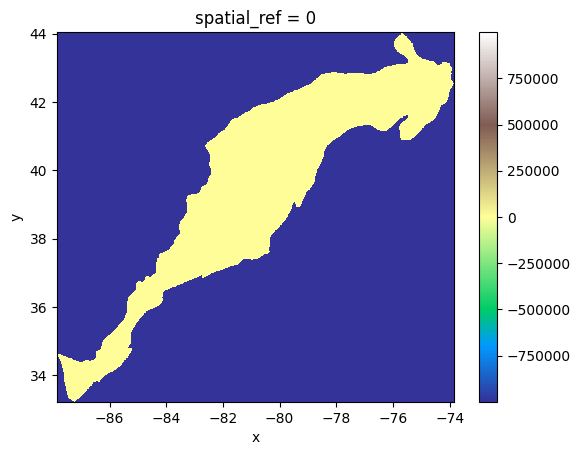

In [7]:
preview = da.isel(x=slice(0, None, 200), y=slice(0, None, 200))
preview.plot.imshow(cmap="terrain", robust=True)